In [4]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0166 - val_loss: 0.0014
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6062e-04 - val_loss: 0.0011
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.5338e-04 - val_loss: 5.6800e-04
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2166e-04 - val_loss: 0.0016
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4731e-04 - val_loss: 0.0013
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9092e-04 - val_loss: 0.0012
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.1806e-04 - val_loss: 4.3815e-04
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5119e-04 - val_loss: 2.4943e-04
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4627e-04 - val_loss: 1.8323e-04
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0722e-04 - val_loss: 2.9214e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error: 24.85163422009476
Mean 

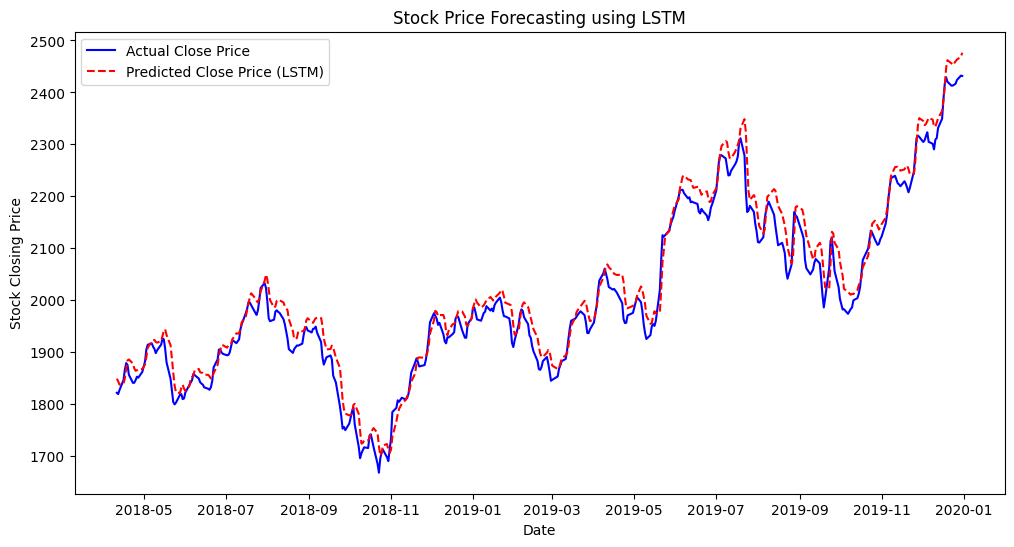

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df = pd.read_csv("/content/HDFC.csv", parse_dates=["Date"], index_col="Date")

# Apply Moving Average Smoothing (window=3)
df['Close_smooth'] = df['Close'].rolling(window=3).mean()
df.dropna(inplace=True)  # Remove NaN values after smoothing

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Close_smooth', 'Open', 'High', 'Low', 'Volume']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting 'Close_smooth'
    return np.array(X), np.array(y)

seq_length = 10  # Use past 10 days to predict next value
X, y = create_sequences(df_scaled, seq_length)

# Split into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict future values
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_inv = scaler.inverse_transform(np.c_[y_pred, np.zeros((len(y_pred), 4))])[:, 0]
y_test_inv = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), 4))])[:, 0]

# Evaluate model
mae = np.mean(np.abs(y_test_inv - y_pred_inv))
mse = np.mean((y_test_inv - y_pred_inv) ** 2)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[len(df) - len(y_test):], y_test_inv, label="Actual Close Price", color='blue')
plt.plot(df.index[len(df) - len(y_test):], y_pred_inv, label="Predicted Close Price (LSTM)", color='red', linestyle='dashed')
plt.title("Stock Price Forecasting using LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Closing Price")
plt.legend()
plt.show()
